# DNN for crash predicition

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
!pip install -q -U tensorflow-addons

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


### Get the data
Training and testing data


In [ ]:
input = {'lean_angle':[71.3, 	82.6, 	91.5, 	103.2, 	85.0, 	59.3, 81.2, 	97.8, 	0,		15.2,	30,		21.3],
           'acceleration X':[2.2, 0.1, 3.1, 2.7, 1.4, 1.0, 0.1,	0, 6, 0.3, 0.6, 0.5],
           'acceleration Y':[0.5,	 3.5, 	0.2, 		0.3, 		1.6,		 0.1, 0.1,		0.3,		0.4,		5,		0.3,		0.5]}
output = {'crash':[1, 	1,		 1,		 1, 		1, 		 0,   0, 		0, 		1,		1,		0,		0]}

test_in = {'lean_angle':[30, 	45, 	20, 	10, 90],
           'acceleration X':[0.6, 1.0, 0.3, 8, 0.2],
           'acceleration Y':[0.5,	 0.1, 0.5,	0.1, 3]}
test_out = {'crash':[0, 0, 0, 1, 1]}


input_dataset = pd.DataFrame(input)
output_dataset = pd.DataFrame(output)

test_data_in = pd.DataFrame(test_in)
test_data_out = pd.DataFrame(test_out)

### Inspect the data


In [ ]:
output_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
crash,12.0,0.583333,0.514929,0.0,0.0,1.0,1.0,1.0


## Normalization

Ideally, data would be normalized using Tensorflow preprocessing normalization, however, frugally-deep does not support this.

In [ ]:
normalizer = preprocessing.Normalization(input_shape=(3,))

In [ ]:
normalizer.adapt(np.array(input_dataset))

This calculates the mean and variance, and stores them in the layer. 

In [ ]:
print(normalizer.mean.numpy())

[61.533  1.5    1.067]


When the layer is called it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(input_dataset[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[71.3  2.2  0.5]]

Normalized: [[ 0.29  0.41 -0.38]]


## A DNN regression
To overcome frugally-deep's limitations the normalization is replaced with a BatchNormalization after the input layer.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      layers.InputLayer(input_shape=(3,)),
      layers.BatchNormalization(),
      layers.Dense(16, activation='relu'),
      layers.Dense(1, activation= 'sigmoid')
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.1), metrics = ['accuracy'])
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 3)                 12        
_________________________________________________________________
dense_144 (Dense)            (None, 16)                64        
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 17        
Total params: 93
Trainable params: 87
Non-trainable params: 6
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    input_dataset, output_dataset,
    validation_split=0.2,
    verbose=1, epochs=100,batch_size=10,validation_batch_size=2)

Epoch 1/100
1/1 [==============================] - 0s 51ms/step - loss: 5.9698e-12 - accuracy: 1.0000 - val_loss: 0.1589 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 5.9681e-12 - accuracy: 1.0000 - val_loss: 0.1368 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 5.9667e-12 - accuracy: 1.0000 - val_loss: 0.1162 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 5.9653e-12 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 5.9641e-12 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 20ms/step - loss: 5.9630e-12 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 5.9620e-12 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy:

Collect the results on the test set:

In [ ]:
test_results = dnn_model.evaluate(test_data_in, test_data_out, verbose=1)

1/1 [==============================] - 0s 1ms/step - loss: 4.3730e-07 - accuracy: 1.0000


## Performance

In [ ]:
pd.DataFrame(test_results)

,0
0,4.373041e-07
1,1.000000e+00


### Make predictions

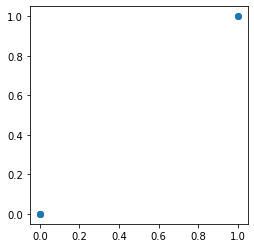

In [ ]:
test_predictions = dnn_model.predict(test_data_in).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_data_out, test_predictions)

_ = plt.plot()

In [ ]:
from keras.models import load_model
dnn_model.save('dnn_model.h5', include_optimizer=False)
dnn_model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 3)                 12        
_________________________________________________________________
dense_144 (Dense)            (None, 16)                64        
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 17        
Total params: 93
Trainable params: 87
Non-trainable params: 6
_________________________________________________________________


Save the model which will later be converted to frugally-deep's json model format

In [ ]:

model = load_model('dnn_model.h5')